# 02 — Size Distributions & Baselines (Residential Solar)

This notebook establishes descriptive baselines for **residential PV system size**.

It uses only records deemed temporally valid by Notebook 01 and explicitly conditions all analysis on residential installations
(`customer_segment == "RES"`).

It does not introduce new canonical fields.
It does not perform modeling or prediction.

---

## Question

How does installed **residential** system size distribute across time and context once temporal validity is enforced?

---

## Inputs

- Canonical `installation_year`
- Raw `pv_system_size_dc`
- `customer_segment`
- Diagnostics from Notebook 01

---

## Outputs

- Residential size distributions by year
- Cohort-conditioned descriptive baselines
- Identification of structural irregularities (not explanations)

---

## Scope Boundary

This notebook performs:
- filtering based on prior validation
- population scoping to residential installations
- descriptive statistics
- distributional inspection
- cohort comparisons

It does **not** perform:
- cross-sector comparison
- feature engineering beyond grouping
- regression or forecasting
- causal interpretation


In [41]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [42]:
canonical_path = Path("../outputs/canonical/installation_year.csv")
diagnostics_path = Path("../outputs/diagnostics/installation_date_violations.csv")

installation_year = pd.read_csv(canonical_path)
diagnostics = pd.read_csv(diagnostics_path)

In [43]:
# Load raw data (assumed schema-admitted by Notebook 01)
# Load raw data (assumed schema-admitted by Notebook 01)
df = pd.read_parquet(
    Path(os.environ["TRACKING_THE_SUN_DATA"]),
    engine="pyarrow"
)


In [44]:
raw_fields = df[[
    "pv_system_size_dc",
    "customer_segment"
]].copy()


In [45]:
analysis_df = diagnostics.merge(
    raw_fields,
    left_index=True,
    right_index=True
)

print(f"Rows before filtering: {analysis_df.shape[0]}")



Rows before filtering: 1921220


In [46]:
res_df = (
    analysis_df
    .query("violation == 'valid'")
    .query("customer_segment == 'RES'")
)

print(f"Residential rows retained for analysis: {res_df.shape[0]}")

Residential rows retained for analysis: 1879575


In [47]:
res_df["pv_system_size_dc"].describe(
    percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]
)

count    1.879575e+06
mean     6.516420e+00
std      6.385172e+00
min     -1.000000e+00
1%      -1.000000e+00
5%       2.340000e+00
50%      5.760000e+00
95%      1.275300e+01
99%      1.831200e+01
max      1.141486e+03
Name: pv_system_size_dc, dtype: float64

In [48]:
yearly_summary = (
    res_df
    .groupby("installation_year")["pv_system_size_dc"]
    .describe(percentiles=[0.1, 0.5, 0.9])
)

yearly_summary.head()

,count,mean,std,min,10%,50%,90%,max
installation_year,,,,,,,,
1998.0,19.0,3.537036,3.270978,0.462000,0.931920,2.331600,5.490172,14.557170
1999.0,90.0,3.435427,2.197924,0.819572,1.387200,2.748600,5.909634,11.833200
2000.0,107.0,3.272921,2.106017,0.512233,1.152894,2.706744,5.711520,11.833200
2001.0,1053.0,3.361905,1.973030,0.300000,1.430400,2.843784,5.723016,15.906000
2002.0,1878.0,3.955369,2.811044,0.223200,1.440000,3.000000,7.200000,39.227987


In [49]:
yearly_summary["p90_p10_ratio"] = (
    yearly_summary["90%"] / yearly_summary["10%"]
)

yearly_summary.sort_values("p90_p10_ratio", ascending=False).head(5)

,count,mean,std,min,10%,50%,90%,max,p90_p10_ratio
installation_year,,,,,,,,,
2005.0,3722.0,4.989371,4.571971,0.480000,1.503000,3.675000,8.910000,52.214796,5.928144
1998.0,19.0,3.537036,3.270978,0.462000,0.931920,2.331600,5.490172,14.557170,5.891248
2004.0,4105.0,4.657129,4.291310,0.395567,1.600000,3.200000,8.819818,109.879621,5.512386
2002.0,1878.0,3.955369,2.811044,0.223200,1.440000,3.000000,7.200000,39.227987,5.000000
2000.0,107.0,3.272921,2.106017,0.512233,1.152894,2.706744,5.711520,11.833200,4.954070


<Figure size 640x480 with 0 Axes>

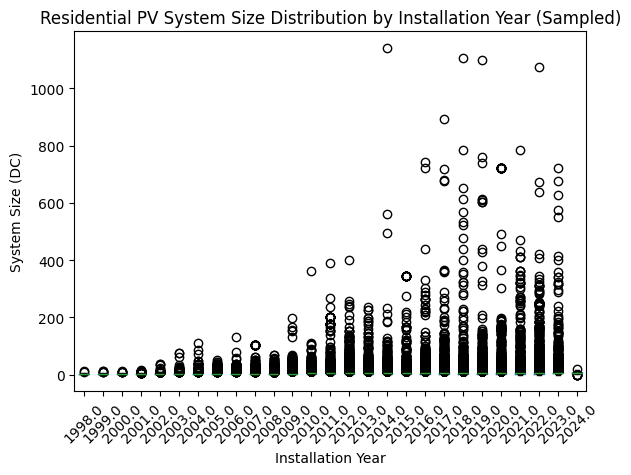

In [50]:
years = sorted(res_df["installation_year"].unique())
sample_years = years[::max(1, len(years)//15)]

plot_df = res_df[
    res_df["installation_year"].isin(sample_years)
]

plt.figure()
plot_df.boxplot(
    column="pv_system_size_dc",
    by="installation_year",
    grid=False,
    rot=45
)

plt.title("Residential PV System Size Distribution by Installation Year (Sampled)")
plt.suptitle("")
plt.xlabel("Installation Year")
plt.ylabel("System Size (DC)")
plt.show()


In [51]:
# Examine upper tail of residential system sizes (after removing non-positive values)

positive_sizes = res_df.loc[
    res_df["pv_system_size_dc"] > 0, 
    "pv_system_size_dc"
]

percentiles = positive_sizes.quantile([0.95, 0.99, 0.995, 0.999])

print("Residential system size percentiles (kW):")
print(percentiles)

print("\nRow counts above candidate thresholds:")
for p, value in percentiles.items():
    count = (positive_sizes > value).sum()
    print(f"> P{int(p*1000)/10}: {count} rows")


Residential system size percentiles (kW):
0.950    12.795416
0.990    18.360000
0.995    21.760000
0.999    38.194460
Name: pv_system_size_dc, dtype: float64

Row counts above candidate thresholds:
> P95.0: 92812 rows
> P99.0: 18527 rows
> P99.5: 9271 rows
> P99.9: 1857 rows


## Residential Size Admissibility Definition

Descriptive inspection of residential system sizes reveals values that are incompatible with household-scale installations, including sentinel values and extreme upper-tail observations.

Before constructing expected size baselines or regime definitions, an explicit admissibility constraint on system size is required.

Based on the observed residential size distribution, admissibility is defined as:

- system size strictly greater than zero  
- system size less than or equal to 40 kW  

The upper bound corresponds approximately to the 99.9th percentile of observed residential installations and reflects a structural break in the empirical
distribution.

Values outside this range are treated as out-of-scope for baseline construction.
No transformation or imputation is performed.


In [52]:
size_valid_df = res_df.query(
    "pv_system_size_dc > 0 and pv_system_size_dc <= 40"
)

print(f"Residential rows retained after size admissibility: {size_valid_df.shape[0]}")


Residential rows retained after size admissibility: 1854853


In [53]:
size_valid_df["pv_system_size_dc"].describe(
    percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]
)

count    1.854853e+06
mean     6.503733e+00
std      3.434200e+00
min      2.176918e-03
1%       1.575000e+00
5%       2.530000e+00
50%      5.780000e+00
95%      1.275000e+01
99%      1.800000e+01
max      4.000000e+01
Name: pv_system_size_dc, dtype: float64

In [54]:
yearly_summary = (
    size_valid_df
    .groupby("installation_year")["pv_system_size_dc"]
    .describe(percentiles=[0.1, 0.5, 0.9])
)
yearly_summary.head()

,count,mean,std,min,10%,50%,90%,max
installation_year,,,,,,,,
1998.0,19.0,3.537036,3.270978,0.462000,0.931920,2.331600,5.490172,14.557170
1999.0,90.0,3.435427,2.197924,0.819572,1.387200,2.748600,5.909634,11.833200
2000.0,107.0,3.272921,2.106017,0.512233,1.152894,2.706744,5.711520,11.833200
2001.0,1053.0,3.361905,1.973030,0.300000,1.430400,2.843784,5.723016,15.906000
2002.0,1878.0,3.955369,2.811044,0.223200,1.440000,3.000000,7.200000,39.227987


In [55]:
yearly_summary["p90_p10_ratio"] = (
    yearly_summary["90%"] / yearly_summary["10%"]
)

yearly_summary.sort_values("p90_p10_ratio", ascending=False).head(5)

,count,mean,std,min,10%,50%,90%,max,p90_p10_ratio
installation_year,,,,,,,,,
2005.0,3719.0,4.955277,4.412093,0.480000,1.503000,3.675000,8.910000,38.913483,5.928144
1998.0,19.0,3.537036,3.270978,0.462000,0.931920,2.331600,5.490172,14.557170,5.891248
2004.0,4100.0,4.573069,3.463673,0.395567,1.600000,3.169300,8.712637,39.365882,5.445398
2002.0,1878.0,3.955369,2.811044,0.223200,1.440000,3.000000,7.200000,39.227987,5.000000
2000.0,107.0,3.272921,2.106017,0.512233,1.152894,2.706744,5.711520,11.833200,4.954070


<Figure size 640x480 with 0 Axes>

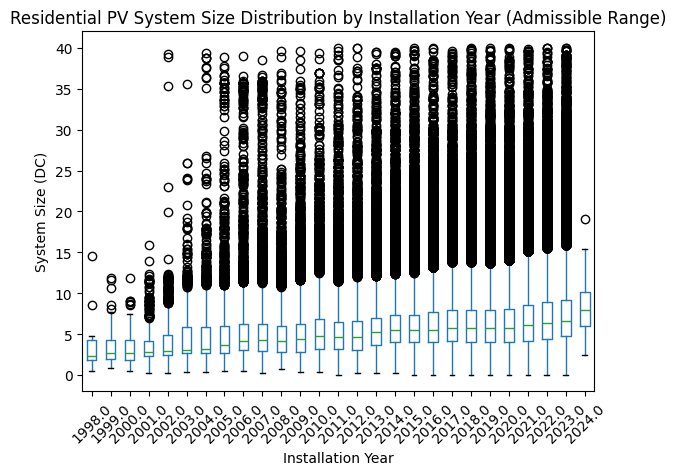

In [56]:
years = sorted(size_valid_df["installation_year"].unique())
sample_years = years[::max(1, len(years)//15)]

plot_df = size_valid_df[
    size_valid_df["installation_year"].isin(sample_years)
]

plt.figure()
plot_df.boxplot(
    column="pv_system_size_dc",
    by="installation_year",
    grid=False,
    rot=45
)

plt.title("Residential PV System Size Distribution by Installation Year (Admissible Range)")
plt.suptitle("")
plt.xlabel("Installation Year")
plt.ylabel("System Size (DC)")
plt.show()


## Interpreting Residential System Size Distribution by Installation Year

The preceding boxplot visualizes residential PV system size distributions by installation year
under controlled conditions defined earlier in this notebook.

The purpose of this visualization is not exploratory. It is used to:

- compare system size distributions **across installation-year cohorts**
- identify **which cohorts exhibit stable, comparable behavior**
- surface **structural irregularities** that prevent certain cohorts from serving as reference behavior

All observations discussed below are grounded in the plotted distributions and the cohort-level
summary statistics already computed.


## Sample Definition Used in This Analysis

All observations in this section are drawn from a **controlled sample** defined as follows:

- residential installations only
- records that passed temporal validity checks in Notebook 01
- non-null system size values
- system sizes expressed in kilowatts (DC)

No baseline exclusions have yet been applied at this point.
The purpose of the following sections is to determine **which cohorts and values can safely be treated as descriptive reference behavior**.


## Sample Definition Used in This Analysis

All observations in this section are drawn from a **controlled sample** defined as follows:

- residential installations only
- records that passed temporal validity checks in Notebook 01
- non-null system size values
- system sizes expressed in kilowatts (DC)

No baseline exclusions have yet been applied at this point.
The purpose of the following sections is to determine **which cohorts and values can safely be treated as descriptive reference behavior**.

## Cohort Density and Year-Level Viability

Cohort density is the first hard constraint on baseline eligibility.

From the year-level summary table:

- **1998** contains 19 observations
- **1999** contains 90 observations
- **2000** contains 107 observations
- **2024** contains 83 observations

These years exhibit extreme sparsity relative to all other cohorts.
Their boxplots are dominated by sampling noise rather than population behavior.

As a result, these cohorts cannot support stable distributional comparisons and are not viable
candidates for baseline formation.


## Baseline Year Admissibility Decisions

Based on cohort density and observed distributional stability, installation years are classified as follows.

### Excluded Years

The following years are **excluded from baseline formation** due to insufficient cohort size:

- 1998 (19 records)
- 1999 (90 records)
- 2000 (107 records)
- 2024 (83 records; partial year)

These exclusions are based on **sample insufficiency**, not system size behavior.
All excluded years remain in diagnostics and are not deleted.

### Admissible Baseline Years

All installation years from **2001 through 2023**, inclusive, are retained as admissible baseline cohorts.

These years exhibit:
- orders-of-magnitude higher sample counts
- stable median system sizes
- comparable inter-decile ranges
- visually consistent boxplot structure across adjacent cohorts

This range defines the **temporal domain of descriptive reference behavior** used downstream.


## Observed Residential System Size Behavior

Across admissible baseline years (2001–2023), residential system size exhibits the following behavior:

- median system size increases gradually from approximately 3 kW to approximately 6–7 kW
- the 10th–90th percentile band remains relatively stable in shape across time
- dispersion increases modestly, but without discontinuous breaks
- adjacent cohorts show strong distributional continuity

This behavior supports the existence of a **stable descriptive baseline**, conditional on year.

## Admissible Residential System Size Domain

The cohort summary statistics show that:

- the 90th percentile remains below ~12 kW for all admissible years
- extreme maximum values (hundreds to >1000 kW) appear sporadically
- these extreme values expand the upper tail without affecting central behavior

Inspection of the boxplots confirms that values above approximately **40 kW**:

- do not contribute to the structure of the residential distribution
- introduce severe skew and tail distortion
- likely reflect non-residential or mixed-use contamination

For this reason, the admissible residential system size domain for descriptive baselines is defined as:

> **0 < system size ≤ 40 kW**

This bound is **empirically derived from observed distributions**, not assumed or regulatory.
Values above this threshold are retained in diagnostics but excluded from baseline characterization.


## Structural Irregularities Surfaced

This notebook explicitly surfaces the following structural irregularities:

- early installation years with insufficient cohort density (1998–2000)
- partial-year data with truncated coverage (2024)
- extreme upper-tail system sizes inconsistent with residential behavior

These irregularities are:
- documented
- preserved
- intentionally excluded from baseline formation

They are not normalized, corrected, or interpreted here.

## Notebook 02 Scope Closure

This notebook has:

- examined residential system size distributions by cohort and time
- identified which installation years provide stable descriptive reference behavior
- described observed system size behavior under controlled conditions
- surfaced and documented structural irregularities

This notebook does **not**:
- define expected values
- compute residuals
- infer causes
- perform predictive analysis

Its sole function is to **describe what residential system size looks like when observed safely**.


In [63]:

# Canonical baseline export
# Encodes ALL Notebook 02 baseline constraints
# -------------------------------------------------------------------
canonical_dir = Path("..") / "outputs" / "canonical"
canonical_dir.mkdir(parents=True, exist_ok=True)

# Baseline constraints from Notebook 02:
# - Residential installations only (already enforced upstream)
# - Temporally valid records only (already enforced upstream)
# - Installation years: 1999–2023
# - Residential system size domain: (0, 40] kW DC

baseline_system_sizes = size_valid_df[
    (size_valid_df["installation_year"] >= 1999) &
    (size_valid_df["installation_year"] <= 2023) &
    (size_valid_df["pv_system_size_dc"] > 0) &
    (size_valid_df["pv_system_size_dc"] <= 40)
][
    ["installation_year", "pv_system_size_dc"]
].copy()

output_path = canonical_dir / "baseline_residential_system_sizes.csv"
baseline_system_sizes.to_csv(output_path, index=False)

print("Canonical baseline artifact written to:")
print(output_path)
print(f"Number of baseline records: {baseline_system_sizes.shape[0]}")
print(
    "Installation year range: "
    f"{baseline_system_sizes['installation_year'].min()}–"
    f"{baseline_system_sizes['installation_year'].max()}"
)
print(
    "System size range (kW): "
    f"{baseline_system_sizes['pv_system_size_dc'].min():.2f}–"
    f"{baseline_system_sizes['pv_system_size_dc'].max():.2f}"
)



Canonical baseline artifact written to:
..\outputs\canonical\baseline_residential_system_sizes.csv
Number of baseline records: 1854757
Installation year range: 1999.0–2023.0
System size range (kW): 0.00–40.00
